In [16]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys


def MovePlots(plotpattern, subplotdir):
    os.system('mkdir -p '+str(sc.settings.figdir)+'/'+subplotdir)
    os.system('mv '+str(sc.settings.figdir)+'/*'+plotpattern+'** '+str(sc.settings.figdir)+'/'+subplotdir)


sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = '/home/jovyan/MULTIOME_july2021/figures_males/'
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable

-----
anndata     0.7.5
scanpy      1.7.0
sinfo       0.3.1
-----
PIL                 8.1.0
anndata             0.7.5
backcall            0.2.0
cairo               1.20.0
cffi                1.14.4
constants           NA
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           4.4.2
get_version         2.1
h5py                3.1.0
highs_wrapper       NA
igraph              0.8.3
ipykernel           5.4.3
ipython_genutils    0.2.0
jedi                0.18.0
joblib              1.0.0
kiwisolver          1.3.1
legacy_api_wrap     1.2
leidenalg           0.8.3
llvmlite            0.35.0
matplotlib          3.3.4
mpl_toolkits        NA
natsort             7.1.1
numba               0.52.0
numexpr             2.7.2
numpy               1.21.2
packaging           20.9
pandas              1.2.1
parso               0.8.1
pexpect             4.8.0
pickleshare         0.7.5
pkg_resources       NA
prompt_toolkit      3.0.14
ptyprocess          0.7.0
pycparser 

'/opt/conda/envs/atac_env/bin/python'

In [17]:
from scanpy import logging as logg
from scanpy.neighbors import neighbors
from anndata import AnnData
from scipy.sparse import csc_matrix
import numpy as np


def woublet(
        adata,
        sim_doublet_ratio=2,
        n_neighbors=30,
        expected_doublet_rate=0.1,
        total_counts_key = 'n_counts',
        copy=False):
    """ Method for detecting mixed-celltype doublets. More documentation coming. In the meantime, email Sam Wolock with questions: swolock@g.harvard.edu
    adata: scanpy AnnData data matrix
    sim_doublet_ratio: number of doublets to simulate, relative to the number of observed transcriptomes (=adata.X.shape[0])
    n_neighbors: number of neighbors used in the k-nearest-neighbor classifier
    expected_doublet_rate: expected frequency of doublets. If unknown, a reasonable guess is 0.05. This parameter rescales the doublet scores but does not affect their ordering.
    total_counts_key: name of the field in adata.obs that contains total counts per cell, used for weighting a cell's relative contribution to simulated doublets. If not present, all cells are weighted equally.
    """
    adata = adata.copy() if copy else adata

    if 'X_pca' not in adata.obsm_keys():
        raise ValueError(
            'Did not find \'X_pca\'. Run `sc.pp.pca` first.')

    if total_counts_key in adata.obs:
        total_counts = np.array(adata.obs[total_counts_key])
    else:
        total_counts = np.ones(adata.X.shape[0])

    # Simulate doublets by averaging PC coordinates of random cell pairs
    logg.info('Simulating doublets')
    PCdat, doub_labels, parent_ix = simulate_doublets_from_pca(adata.obsm['X_pca'], 
        total_counts=total_counts, 
        sim_doublet_ratio=sim_doublet_ratio)


    adata_doub = AnnData(csc_matrix((PCdat.shape[0], 1)))
    adata_doub.obsm['X_pca'] = PCdat

    # Calculate doublet scores using k-nearest-neighbor classifier
    logg.info('Running KNN classifier')
    adata.obs['doublet_score'], adata.uns['sim_doublet_score'] = calculate_doublet_scores(
        adata_doub, 
        doub_labels, 
        n_neighbors=n_neighbors, 
        expected_doublet_rate = expected_doublet_rate)

    adata.obs['doublet_score']

    return adata if copy else None



#========================================================================================#

def simulate_doublets_from_pca(PCdat, total_counts=[], sim_doublet_ratio=1):
    '''
    Simulate doublets by averaging PCA coordinates of random cell pairs.
    Average is weighted by total counts of each parent cell, if provided.

    Returns:
    PCdoub (matrix of size (num_cells+num_sim_doubs, num_pcs)): PCA matrix with the simulated doublet PCA coordinates appended to the original data matrix PCdat.
    doub_labels (array of size (num_cells+num_sim_doubs)): 0 if observed cell, 1 if simulated doublet
    pair_ix (matrix of size(num_sim_doubs, 2)): each row gives the indices of the parent cells used to generate the simulated doublet
    '''

    n_obs = PCdat.shape[0]
    n_doub = int(n_obs * sim_doublet_ratio)

    if len(total_counts) == 0:
        total_counts = np.ones(n_obs)

    pair_ix = np.random.randint(0, n_obs, size=(n_doub, 2))

    pair_tots = np.hstack((total_counts[pair_ix[:, 0]][:,None], total_counts[pair_ix[:, 1]][:,None]))
    pair_tots = np.array(pair_tots, dtype=float)
    pair_fracs = pair_tots / np.sum(pair_tots, axis=1)[:,None]

    PCdoub = PCdat[pair_ix[:, 0],:] * pair_fracs[:, 0][:,None] + PCdat[pair_ix[:, 1],:] * pair_fracs[:, 1][:,None]

    PCdoub = np.vstack((PCdat, PCdoub))
    doub_labels = np.concatenate((np.zeros(n_obs), np.ones(n_doub)))

    return PCdoub, doub_labels, pair_ix

#========================================================================================#

def calculate_doublet_scores(adata, doub_labels, n_neighbors=30, expected_doublet_rate = 1.0):
    n_obs = sum(doub_labels == 0)
    n_sim = sum(doub_labels == 1)

    # Adjust k (number of nearest neighbors) based on the ratio of simulated to observed cells
    k_adj = int(round(n_neighbors * (1+n_sim/float(n_obs))))

    # Find k_adj nearest neighbors
    neighbors(adata, n_neighbors = k_adj, use_rep = 'X_pca')

    # Calculate doublet score based on ratio of simulated cell neighbors vs. observed cell neighbors
    matrix = adata.obsp['distances']
    n_sim_neigh = (matrix[:,doub_labels == 1]>0).sum(1).A.squeeze()
    n_obs_neigh = (matrix[:,doub_labels == 0]>0).sum(1).A.squeeze()
    
    doub_score = n_sim_neigh / (n_sim_neigh + n_obs_neigh * n_sim / float(n_obs) / expected_doublet_rate)
    doub_score_obs = doub_score[doub_labels == 0]

    # return doublet scores for observed cells and simulated cells
    return doub_score[doub_labels == 0], doub_score[doub_labels == 1]

In [18]:
# Define variables
outdir = "/nfs/team292/vl6/my_MULTIOME_dir/males_sept2021/"
experiment_prefix = 'males_'

In [19]:
adata = sc.read_h5ad(outdir + experiment_prefix + "_ATAC.wCisTopic.h5ad")
adata

AnnData object with n_obs × n_vars = 54542 × 184906
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'multiome_GermCells', 'multiome_Somatic', 'code', 'sample', 'sex', 'stage', 'individual'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'chromosome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cellatac_clusters_colors', 'individual_colors', 'neighbors', 'sample_colors', 'stage_colors', 'umap'
    obsm: 'X_cistopic_38', 'X_umap'
    varm: 'peak2gene'
    layers: 'binary_raw'
    obsp: 'connectivities', 'distances'

In [20]:
# Estimate doublet scoper per sample and set to 0
holder = np.zeros((adata.shape[0],))
for smp in np.unique(adata.obs['sample']):
    print(smp)
    adata_smp = adata[adata.obs['sample']==smp]
    sc.tl.pca(adata_smp)
    woublet(adata_smp)
    holder[adata.obs['sample']==smp] = adata_smp.obs['doublet_score']
adata.obs['doublet_score'] = holder

computing PCA
    with n_comps=50


FCA_GND8768481


    finished (0:00:39)
Simulating doublets
Running KNN classifier
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
/opt/conda/envs/atac_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
computing PCA
    with n_comps=50


FCA_GND8768482


    finished (0:01:10)
Simulating doublets
Running KNN classifier
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:07)
/opt/conda/envs/atac_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
computing PCA
    with n_comps=50


FCA_GND8768487


    finished (0:00:13)
Simulating doublets
Running KNN classifier
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
/opt/conda/envs/atac_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
computing PCA
    with n_comps=50


FCA_GND8795927


    finished (0:01:23)
Simulating doublets
Running KNN classifier
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:19)
/opt/conda/envs/atac_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
computing PCA
    with n_comps=50


FCA_GND8795928


    finished (0:01:08)
Simulating doublets
Running KNN classifier
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:11)
/opt/conda/envs/atac_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
computing PCA
    with n_comps=50


FCA_GND9332157


    finished (0:00:49)
Simulating doublets
Running KNN classifier
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:13)
/opt/conda/envs/atac_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
computing PCA
    with n_comps=50


HCA_F_GON10687819


    finished (0:00:45)
Simulating doublets
Running KNN classifier
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:14)
/opt/conda/envs/atac_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
computing PCA
    with n_comps=50


HCA_F_GON10687820


    finished (0:00:57)
Simulating doublets
Running KNN classifier
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:15)
/opt/conda/envs/atac_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
computing PCA
    with n_comps=50


HD_F_GON9479872


    finished (0:01:16)
Simulating doublets
Running KNN classifier
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:12)
/opt/conda/envs/atac_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
computing PCA
    with n_comps=50


HD_F_GON9525611


    finished (0:00:50)
Simulating doublets
Running KNN classifier
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
/opt/conda/envs/atac_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
computing PCA
    with n_comps=50


HD_F_GON9525612


    finished (0:00:55)
Simulating doublets
Running KNN classifier
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
/opt/conda/envs/atac_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
computing PCA
    with n_comps=50


HD_F_GON9883955


    finished (0:01:31)
Simulating doublets
Running KNN classifier
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:13)
/opt/conda/envs/atac_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
computing PCA
    with n_comps=50


HD_F_GON9883958


    finished (0:01:12)
Simulating doublets
Running KNN classifier
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:13)


In [21]:
# Check doublets distribution
adata.obs['doublet_score_0.75'] = adata.obs['doublet_score'] > 0.75
adata.obs['doublet_score_0.75'] = adata.obs['doublet_score_0.75'].astype(int)

In [22]:
new_palette = ['saddlebrown', 'red', 'darkorange', 'gold', 'olivedrab', 'limegreen', 
              'dodgerblue', 'blueviolet', 'deeppink', 'aliceblue']

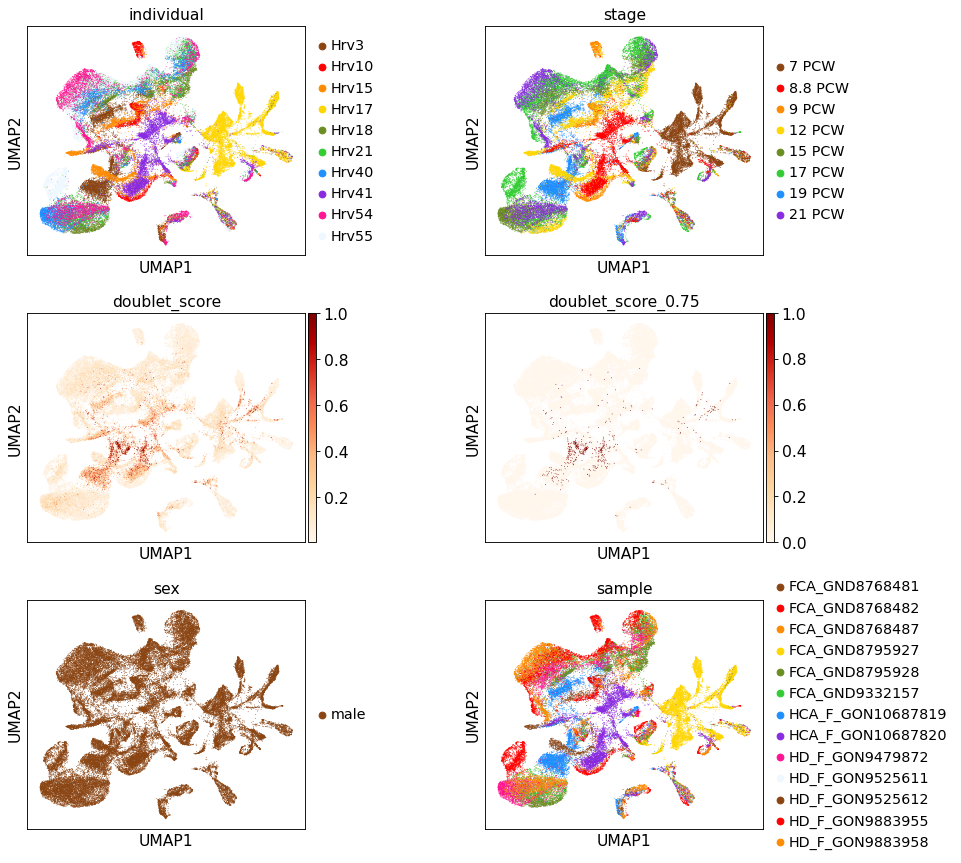

In [23]:
sc.pl.umap(adata, color = ['individual', 'stage', 'doublet_score', 'doublet_score_0.75', 'sex', 'sample'],
           ncols = 2, color_map = 'OrRd', save = '_pre_doublet.pdf', wspace = 0.5, 
          palette = new_palette)

#### Remove doublets

/opt/conda/envs/atac_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.uns` of view, copying.


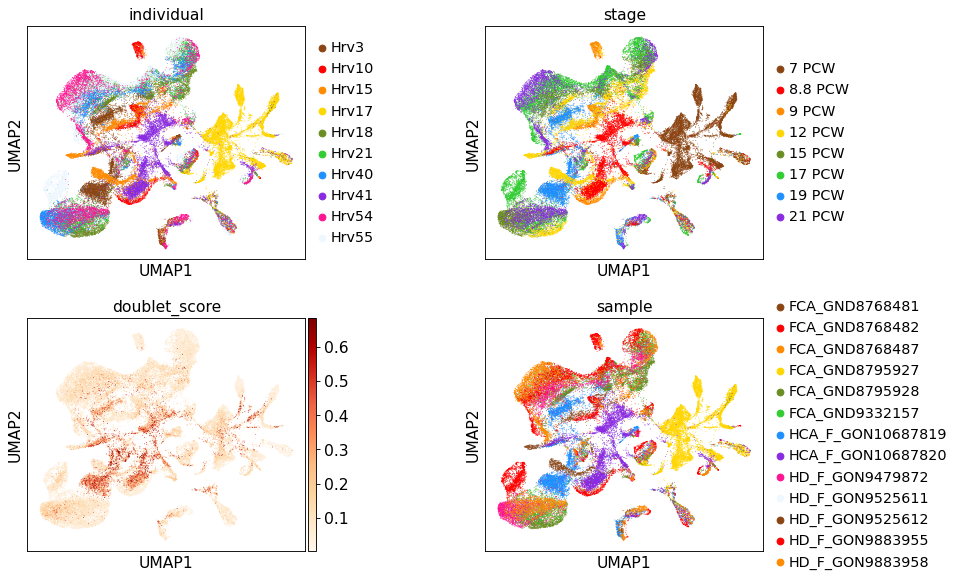

In [24]:
adata = adata[[i != 1 for i in adata.obs['doublet_score_0.75']]]
adata.shape
sc.pl.umap(adata, color = ['individual', 'stage', 'doublet_score', 'sample'],
           ncols = 2, color_map = 'OrRd', save = '_post_doublet.pdf', wspace = 0.5, 
          palette = new_palette)

In [25]:
gene_data = sc.read_h5ad(outdir + experiment_prefix + "_ATAC.geneScores.h5ad")
gene_data

AnnData object with n_obs × n_vars = 54542 × 19085
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'multiome_GermCells', 'multiome_Somatic', 'code', 'sample', 'sex', 'stage', 'individual'
    var: 'gene_id'
    uns: 'neighbors', 'umap'
    obsm: 'X_cistopic_38', 'X_umap'
    obsp: 'connectivities', 'distances'

In [26]:
gene_data = gene_data[list(adata.obs_names), ]
gene_data.shape

/opt/conda/envs/atac_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(54045, 19085)

#### Save without doublets

In [27]:
gene_data.write(outdir + experiment_prefix + "_ATAC.geneScores.h5ad")

In [28]:
adata.write(outdir + experiment_prefix + "_ATAC.wCisTopic.h5ad")

In [29]:
np.unique(adata.obs['individual'])

array(['Hrv10', 'Hrv15', 'Hrv17', 'Hrv18', 'Hrv21', 'Hrv3', 'Hrv40',
       'Hrv41', 'Hrv54', 'Hrv55'], dtype=object)

In [30]:
adata

AnnData object with n_obs × n_vars = 54045 × 184906
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'multiome_GermCells', 'multiome_Somatic', 'code', 'sample', 'sex', 'stage', 'individual', 'doublet_score', 'doublet_score_0.75'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'chromosome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cellatac_clusters_colors', 'individual_colors', 'neighbors', 'sample_colors', 'stage_colors', 'umap', 'sex_colors'
    obsm: 'X_cistopic_38', 'X_umap'
    varm: 'peak2gene'
    layers: 'binary_raw'
    obsp: 'connectivities', 'distances'